In [1]:
import numpy as np
import torch
import gpytorch
from matplotlib import pyplot as plt
import matplotlib as mpl
from gpytorch.kernels import ScaleKernel, RBFKernel, PeriodicKernel
from botorch.models import SingleTaskGP
from botorch.fit import fit_gpytorch_model
from gpytorch.mlls import ExactMarginalLogLikelihood
from gpytorch.constraints import Interval
from gpytorch.priors import NormalPrior

# this is just for fancy plots
def set_matplotlib_params():

    """Set matplotlib params."""

    mpl.rcParams.update(mpl.rcParamsDefault)
    mpl.rc("font", family="serif")
    mpl.rcParams.update(
        {
            "font.size": 24,
            "lines.linewidth": 2,
            "axes.labelsize": 24,  # fontsize for x and y labels
            "axes.titlesize": 24,
            "xtick.labelsize": 20,
            "ytick.labelsize": 20,
            "legend.fontsize": 20,
            "axes.linewidth": 2,
            "pgf.texsystem": "pdflatex",  # change this if using xetex or lautex
            "text.usetex": True,  # use LaTeX to write all text
            "axes.spines.right": False,
            "axes.spines.top": False,
            "axes.spines.left": True,
            "axes.spines.bottom": True,
            "legend.shadow": True,
            "legend.fancybox": True,
            "text.latex.preamble": [r"\usepackage{amsmath}"],
        }
    )

set_matplotlib_params()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
torch.set_default_dtype(torch.double)
torch.set_default_tensor_type(torch.DoubleTensor)

ValueError: Key text.latex.preamble: Could not convert ['\\usepackage{amsmath}'] to str

# The data

In [2]:
seed = 7
torch.manual_seed(seed)
np.random.seed(seed)
rng = np.random.default_rng(seed)


noise = .1
npts = 100
ntrain = 20
T = 48
t = torch.linspace(0, T, npts)
per = 24

def oscillations(t, per):
    return torch.sin(t * (2 * np.pi) / per)

f =  oscillations(t, per)
train_idx = rng.choice(range(npts), ntrain, replace=False)
train_x = t[train_idx].view(-1, 1)
train_y = oscillations(train_x, per) + torch.randn(train_x.size()) * np.sqrt(noise)
train_y = train_y.view(-1, 1)

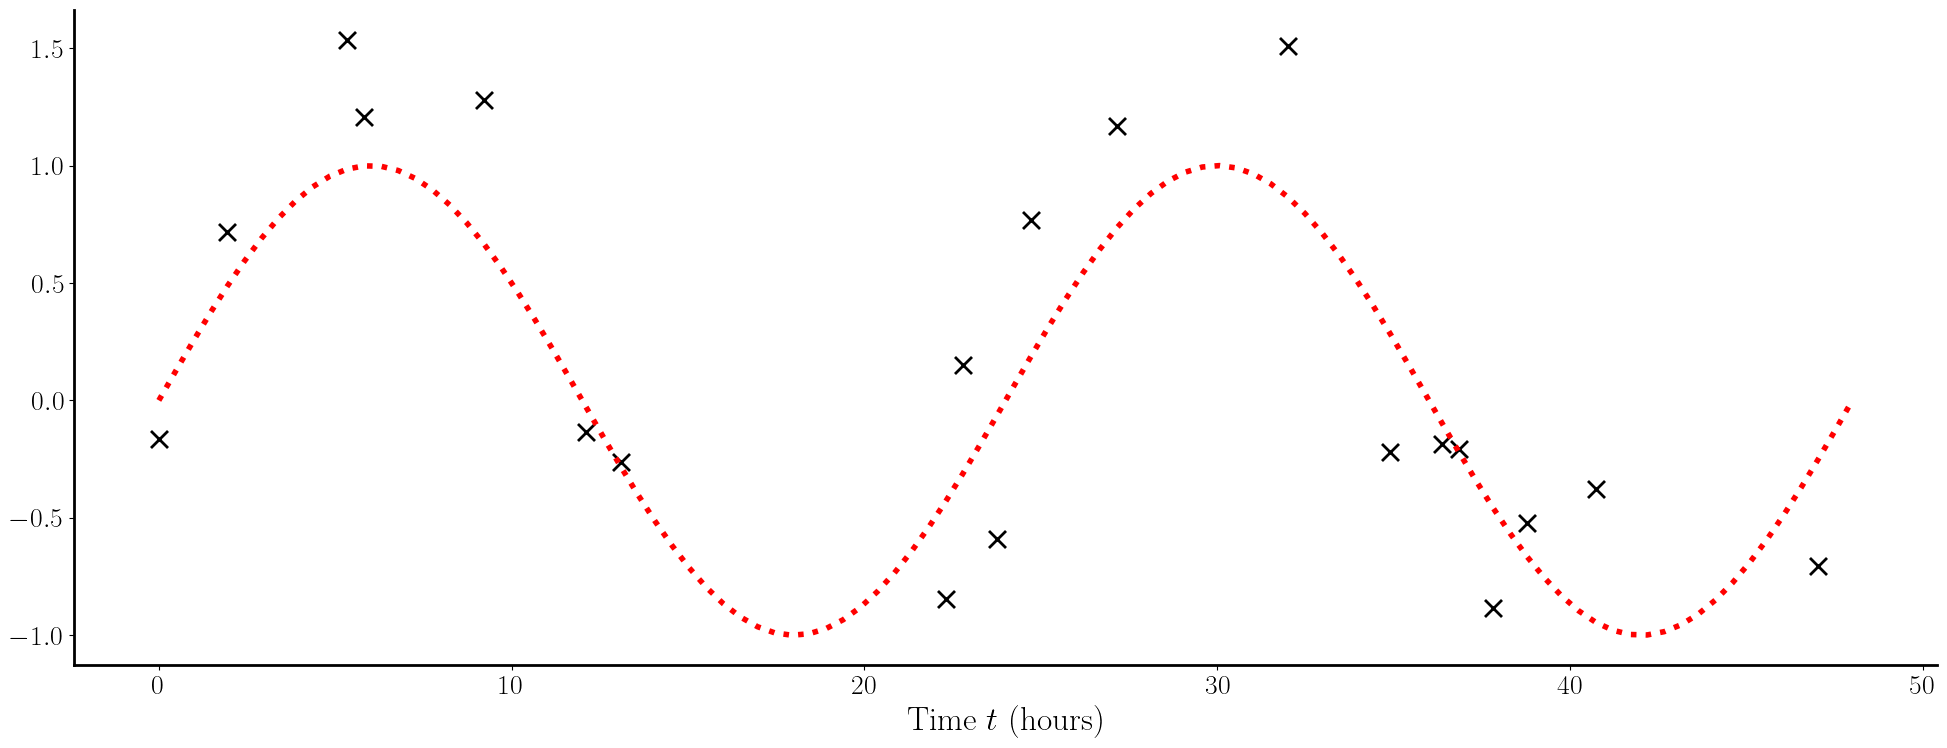

In [3]:
fig, axes = plt.subplots(1, 1, figsize=(20,8))
axes.plot(t, f, linestyle='dotted', color='red', linewidth=4) # latent function
axes.scatter(train_x, train_y, marker='x', color='black', s=150) # noisy observations data
axes.set_xlabel('Time $t$ (hours)')
fig.tight_layout()
plt.show()

# The model

In [4]:
k = ScaleKernel(RBFKernel()) # Scale kernel adds the amplitude hyperparameter to the kernel
model = SingleTaskGP(train_x, train_y,
                     covar_module=k)

mll = ExactMarginalLogLikelihood(model.likelihood, model)
fit_gpytorch_model(mll);

/opt/miniconda3/lib/python3.9/site-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
/opt/miniconda3/lib/python3.9/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


In [5]:
preds = model(t)
mean = preds.mean
var = preds.variance

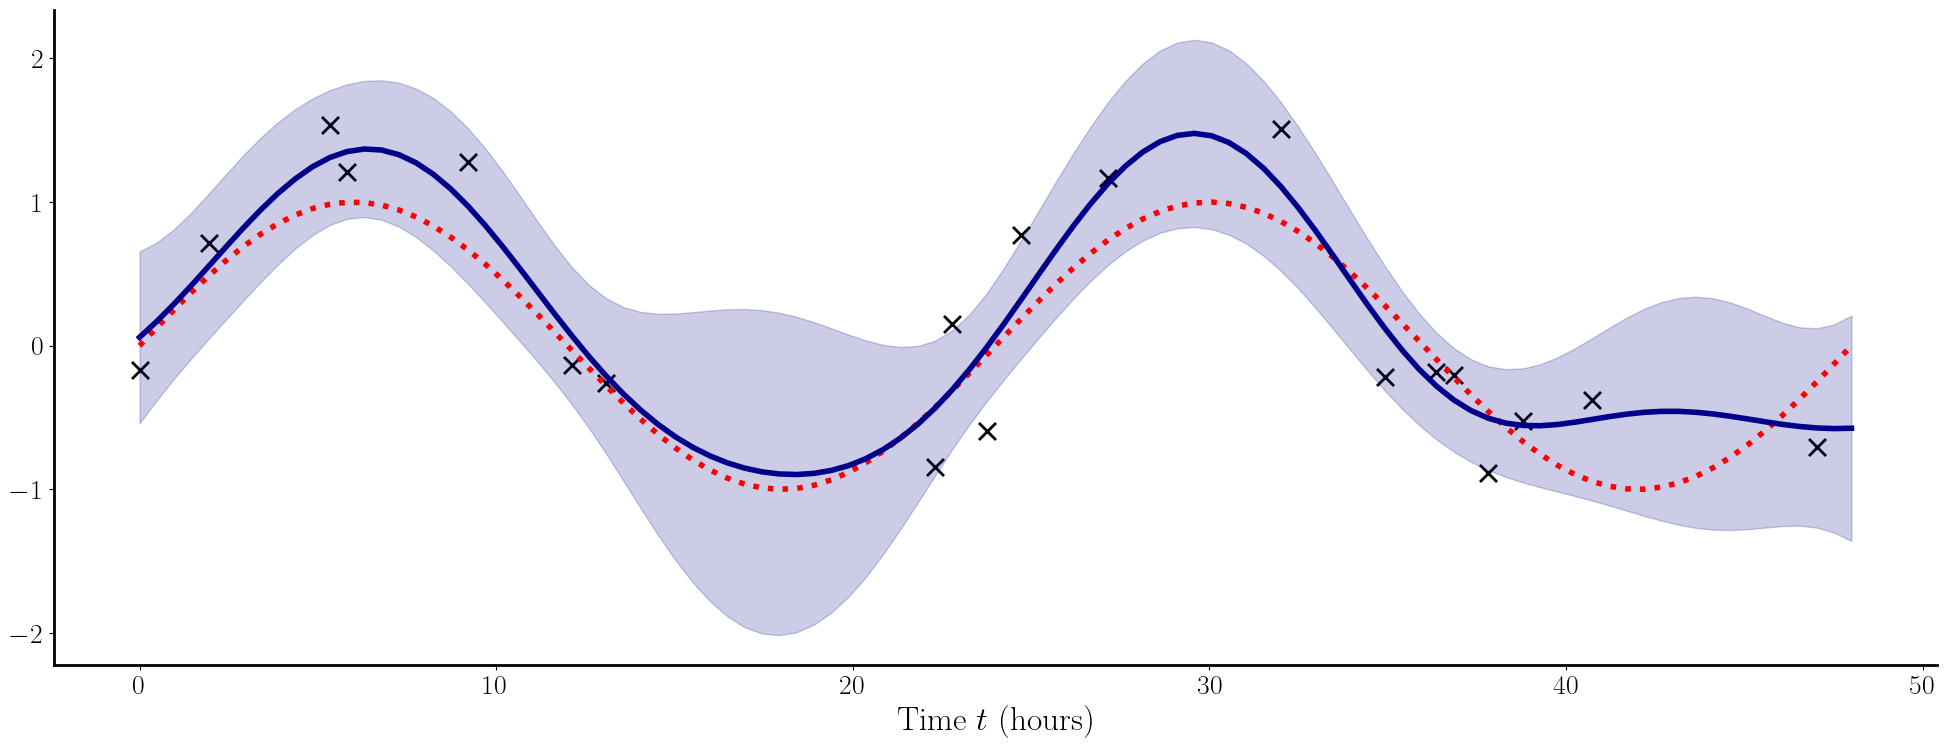

In [6]:
with torch.no_grad():
        fig, axes = plt.subplots(1, 1, figsize=(20,8))
        axes.plot(t, f, linestyle='dotted', color='red', linewidth=4) # latent function
        axes.scatter(train_x, train_y, marker='x', color='black', s=150) # noisy observations data

        axes.plot(t, mean, color='darkblue', linewidth=4)
        axes.fill_between(t, mean - 2*torch.sqrt(var), mean + 2*torch.sqrt(var),
                           alpha=.2, color='darkblue')
        axes.set_xlabel('Time $t$ (hours)')
        fig.tight_layout()
        plt.show()

Pas si mal. Cependant, si on effectue des prédictions en dehors de la distribution des données, si l'on demande d'extrapoler donc:

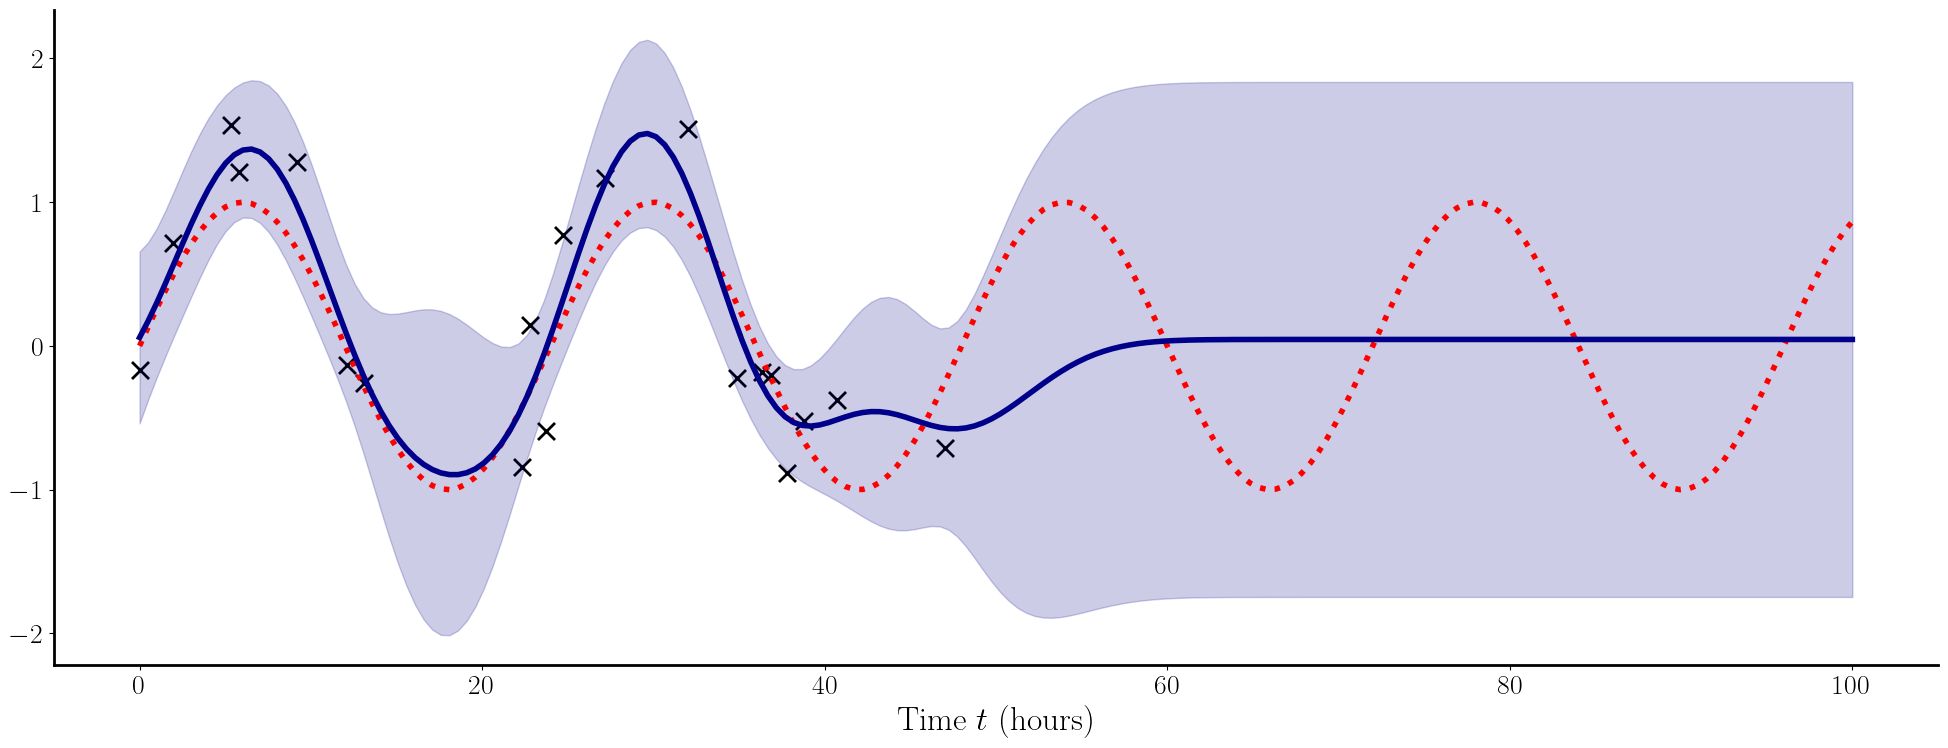

In [7]:
T_OOD = 100
t_OOD = torch.linspace(0, T_OOD, 2 * npts)
f_OOD = oscillations(t_OOD, per)

preds_OOD = model(t_OOD)
mean_OOD = preds_OOD.mean
var_OOD = preds_OOD.variance

with torch.no_grad():
        fig, axes = plt.subplots(1, 1, figsize=(20,8))
        axes.plot(t_OOD, f_OOD, linestyle='dotted', color='red', linewidth=4) # latent function
        axes.scatter(train_x, train_y, marker='x', color='black', s=150) # noisy observations data

        axes.plot(t_OOD, mean_OOD, color='darkblue', linewidth=4)
        axes.fill_between(t_OOD, mean_OOD - 2*torch.sqrt(var_OOD), mean_OOD + 2*torch.sqrt(var_OOD),
                           alpha=.2, color='darkblue')
        axes.set_xlabel('Time $t$ (hours)')
        fig.tight_layout()
        plt.show()

En dehors des données, les trajectoires reviennent au prior : $m(x) = E[f(x)] = 0$, car nous n'avons pas précisé de prior mean.

Une solution simple consiste à utiliser un noyau périodique.

In [8]:
k_per = ScaleKernel(PeriodicKernel()) # Scale kernel adds the amplitude hyperparameter to the kernel
model_per = SingleTaskGP(train_x, train_y,
                     covar_module=k_per)

mll_per = ExactMarginalLogLikelihood(model_per.likelihood, model_per)
fit_gpytorch_model(mll_per, max_retries=10);

/opt/miniconda3/lib/python3.9/site-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
/opt/miniconda3/lib/python3.9/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


In [9]:
preds_per = model_per(t_OOD)
mean_per = preds_per.mean
var_per = preds_per.variance

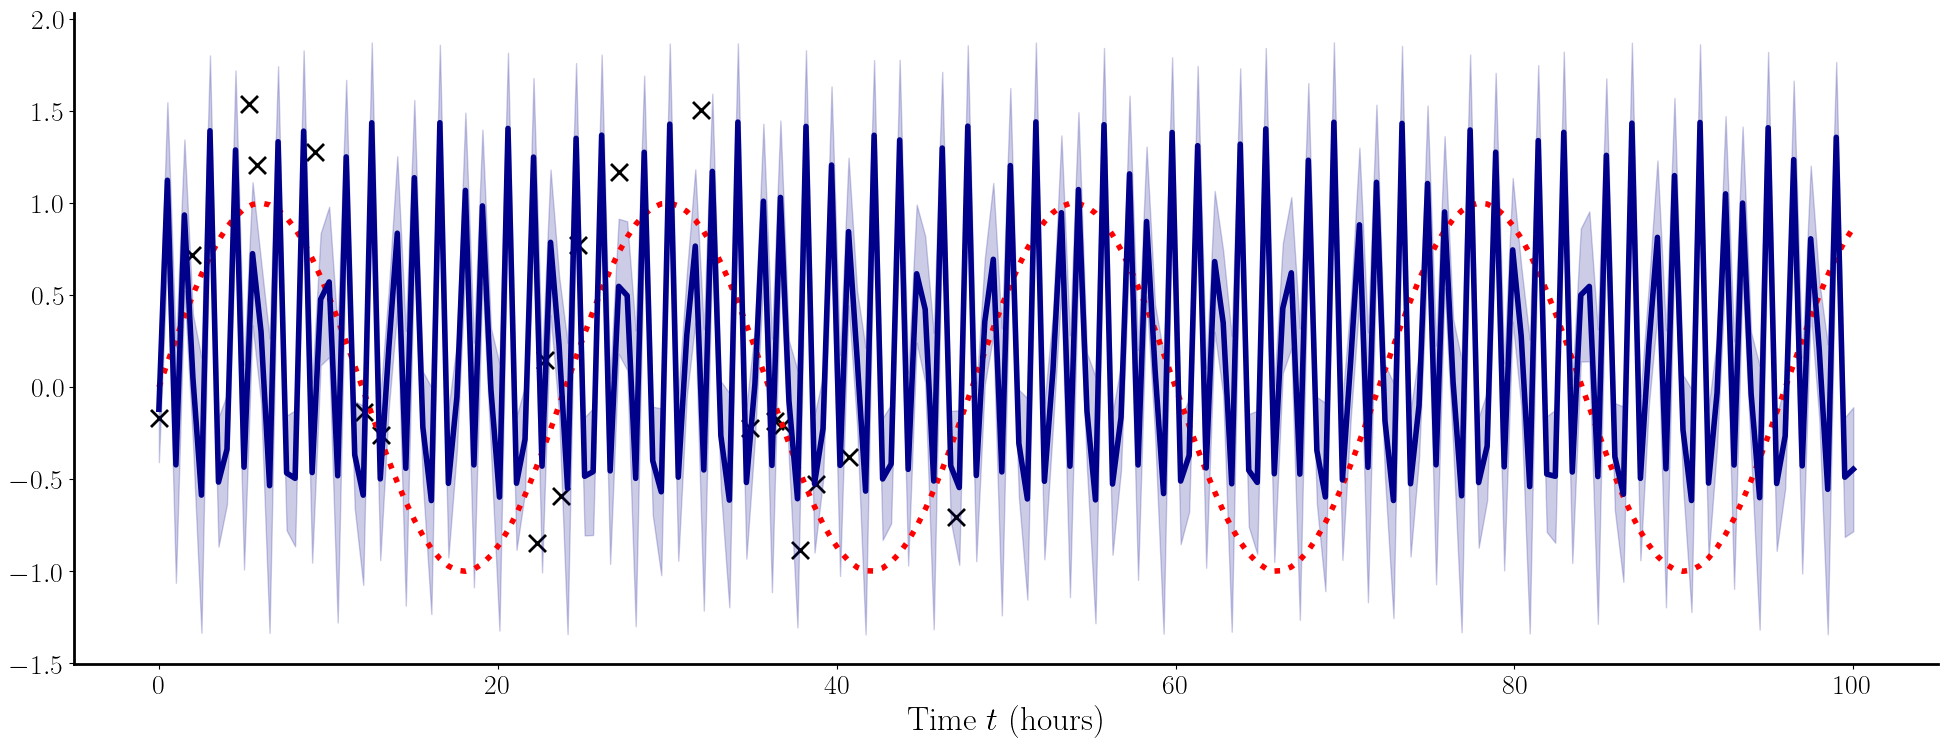

In [10]:
with torch.no_grad():
        fig, axes = plt.subplots(1, 1, figsize=(20,8))
        axes.plot(t_OOD, f_OOD, linestyle='dotted', color='red', linewidth=4) # latent function
        axes.scatter(train_x, train_y, marker='x', color='black', s=150) # noisy observations data

        axes.plot(t_OOD, mean_per, color='darkblue', linewidth=4)
        axes.fill_between(t_OOD, mean_per - 2*torch.sqrt(var_per), mean_per + 2*torch.sqrt(var_per),
                           alpha=.2, color='darkblue')
        axes.set_xlabel('Time $t$ (hours)')
        fig.tight_layout()
        plt.show()

Ah, ce n'est pas exactement ce que l'on attendait non plus... Beaucoup de façon de résoudre ce problème, la plus simple ici est sans doute d'imposer une contrainte sur la période.

In [11]:
k_per = ScaleKernel(PeriodicKernel(period_length_constraint=Interval(20, 28))) # Scale kernel adds the amplitude hyperparameter to the kernel
model_per = SingleTaskGP(train_x, train_y,
                     covar_module=k_per)

mll_per = ExactMarginalLogLikelihood(model_per.likelihood, model_per)
fit_gpytorch_model(mll_per, max_retries=10);

/opt/miniconda3/lib/python3.9/site-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
/opt/miniconda3/lib/python3.9/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


In [12]:
preds_per = model_per(t_OOD)
mean_per = preds_per.mean
var_per = preds_per.variance

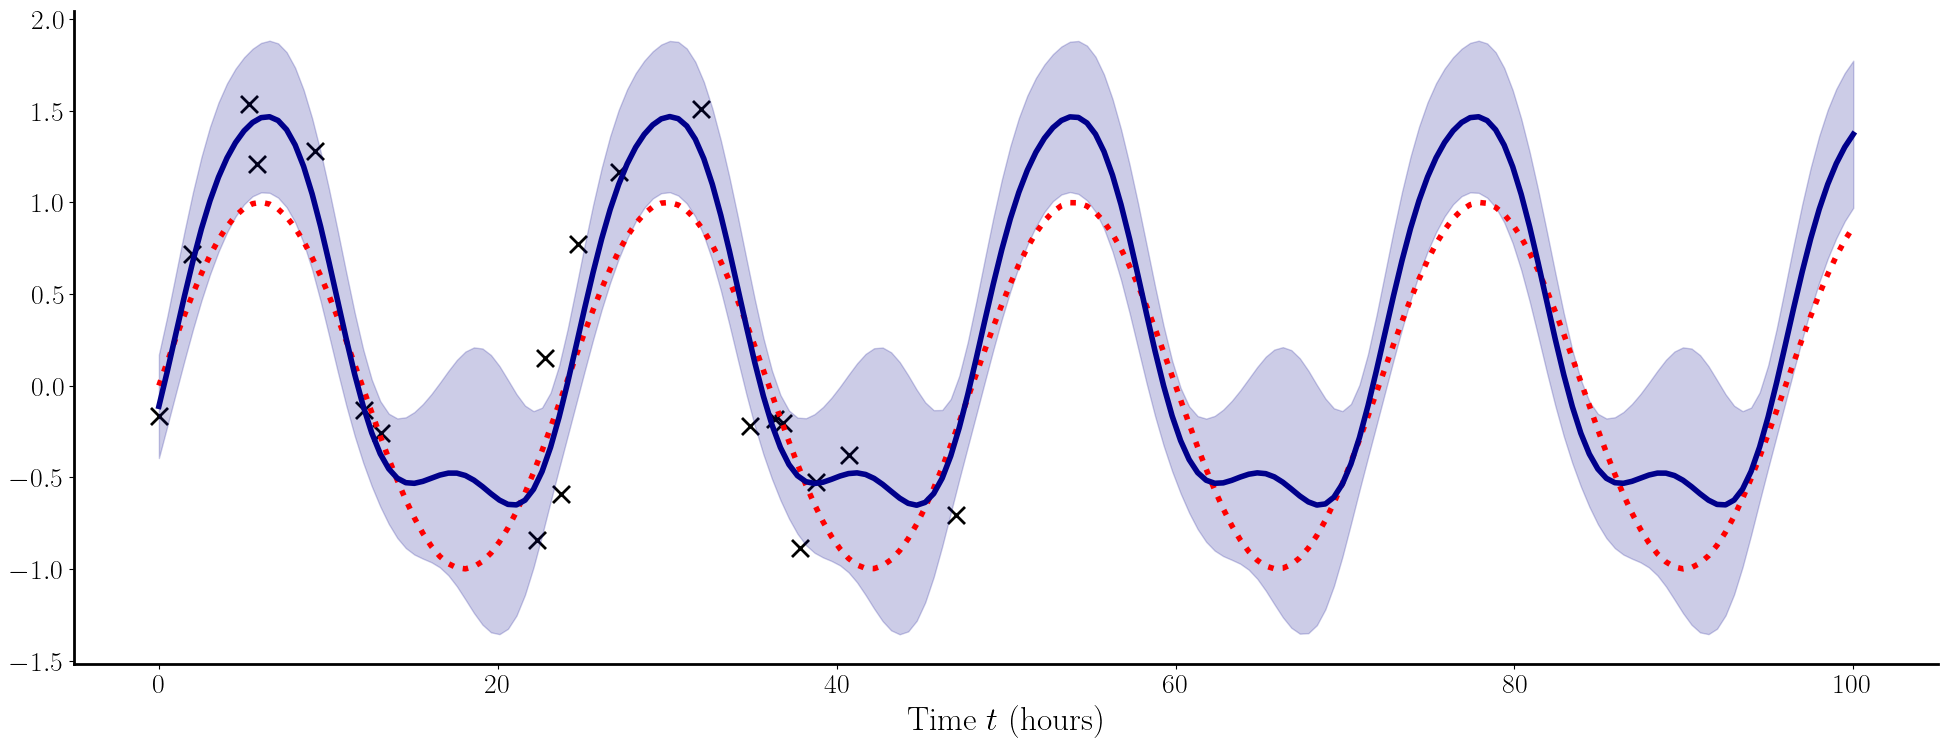

In [13]:
with torch.no_grad():
        fig, axes = plt.subplots(1, 1, figsize=(20,8))
        axes.plot(t_OOD, f_OOD, linestyle='dotted', color='red', linewidth=4) # latent function
        axes.scatter(train_x, train_y, marker='x', color='black', s=150) # noisy observations data

        axes.plot(t_OOD, mean_per, color='darkblue', linewidth=4)
        axes.fill_between(t_OOD, mean_per - 2*torch.sqrt(var_per), mean_per + 2*torch.sqrt(var_per),
                           alpha=.2, color='darkblue')
        axes.set_xlabel('Time $t$ (hours)')
        fig.tight_layout()
        plt.show()

Le  résultat est plus satisfaisant. Regardons un peu les paramètres.

In [14]:
print(f'Period: {model_per.covar_module.base_kernel.period_length.item()}')
print(f'Amplitude: {model_per.covar_module.outputscale.item()}')
print(f'Lengthscale: {model_per.covar_module.base_kernel.lengthscale.item()}')
print(f'Noise: {model.likelihood.noise.item()}')

Period: 23.783679945197235
Amplitude: 0.7716712464232874
Lengthscale: 1.0007813469817595
Noise: 0.146043602916491


La période récupérée est assez proche de la véritable période. Le bruit est parfaitement estimé.

L'amplitude caractériste l'incertitude __épistémique__ du modèle, c'est à dire l'incertitude liée au fait que tu cherches à estimer un objet de dimension infinie (une fonction) à partir d'un nombre fini d'observations : il y a une infinité de trajectoires qui passent par ces points, et l'intervalle de confiance contenant ces trajectoires peut être obtenu via l'amplitude. C'est une incertitude différente de celle liée au fait que tes observations sont bruitées, les deux s'additionnent. J'ajoute quelques réalisations du processus gaussien à posteriori pour illustrer mon propos.

Finalement, le lengthscale décrit à quel point la corrélation entre deux sorties $f(x_1) f(x_2)$ décroit à mesure que la distance entre $x_1$ et $x_2$ s'accroit. Plus le lengthscale est elevé, plus la corrélation décroit lentement. Dans la limite $\ell \to +\infty, Cov[f(x_1), f(x_2)] = 1~\forall (x_1,x_2)$. Autrement dit, les réalisation du processus sont des droites. Inversement, si $\ell \to 0, Cov[f(x_1), f(x_2)] = 0~\forall (x_1,x_2)$, et les trajectoires sont erratiques, à juste titre : même pour deux entrées $x_1$ et $x_2$ très proches, connaître $f(x_1)$ ne t'informe absolument pas sur $f(x_2)$, puisque la covariance entre ces deux variables est nulle. C'est typiquement ce paramètre qui va déterminer le caractère "lisse" des trajectoires.

Tous ces hyperparamètres sont estimés par maximisation de la vraisemblance marginale.

/opt/miniconda3/lib/python3.9/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(


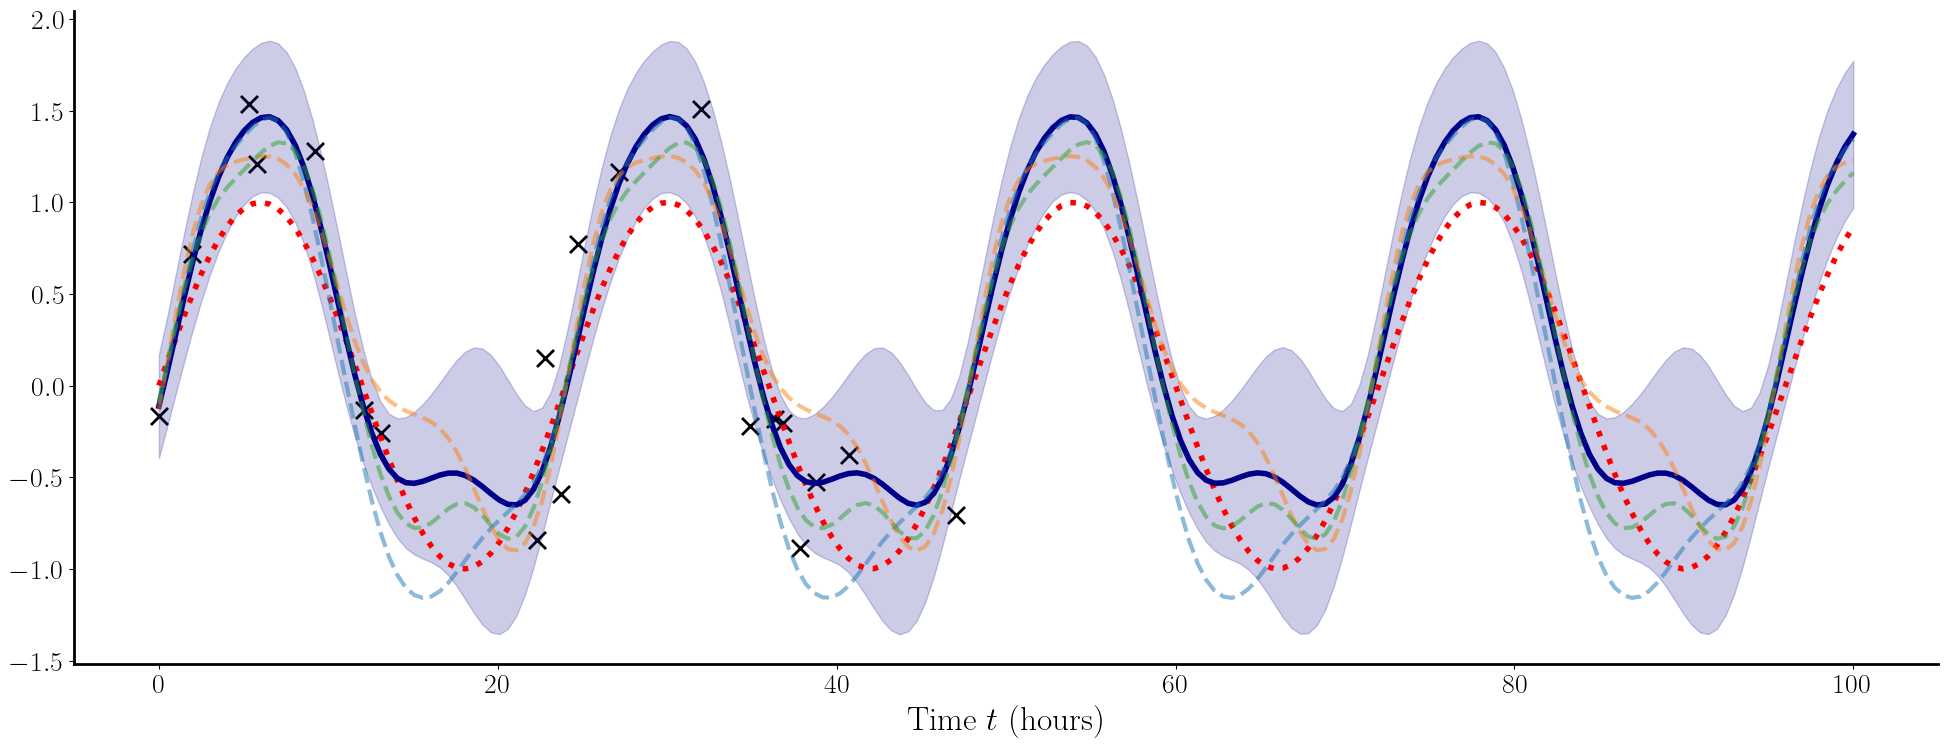

In [15]:
with torch.no_grad():
        fig, axes = plt.subplots(1, 1, figsize=(20,8))
        axes.plot(t_OOD, f_OOD, linestyle='dotted', color='red', linewidth=4) # latent function
        axes.scatter(train_x, train_y, marker='x', color='black', s=150) # noisy observations data

        axes.plot(t_OOD, mean_per, color='darkblue', linewidth=4)
        axes.fill_between(t_OOD, mean_per - 2*torch.sqrt(var_per), mean_per + 2*torch.sqrt(var_per),
                           alpha=.2, color='darkblue')
        
        for _ in range(3):
            axes.plot(t_OOD, preds_per.sample(), linestyle='--', alpha=.5, linewidth=3)
        axes.set_xlabel('Time $t$ (hours)')
        fig.tight_layout()
        plt.show()

On peut aussi se placer dans le cas où on ne souhaite pas optimiser la période.

In [16]:
k_per = ScaleKernel(PeriodicKernel()) # Scale kernel adds the amplitude hyperparameter to the kernel
model_per = SingleTaskGP(train_x, train_y,
                     covar_module=k_per)
# fixing the period hyperparameter
model_per.covar_module.base_kernel.period_length = 24
# disabling training for it once it has been fixed. 
model_per.covar_module.base_kernel.raw_period_length.requires_grad_(False)

mll_per = ExactMarginalLogLikelihood(model_per.likelihood, model_per)
fit_gpytorch_model(mll_per, max_retries=10);

/opt/miniconda3/lib/python3.9/site-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
/opt/miniconda3/lib/python3.9/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


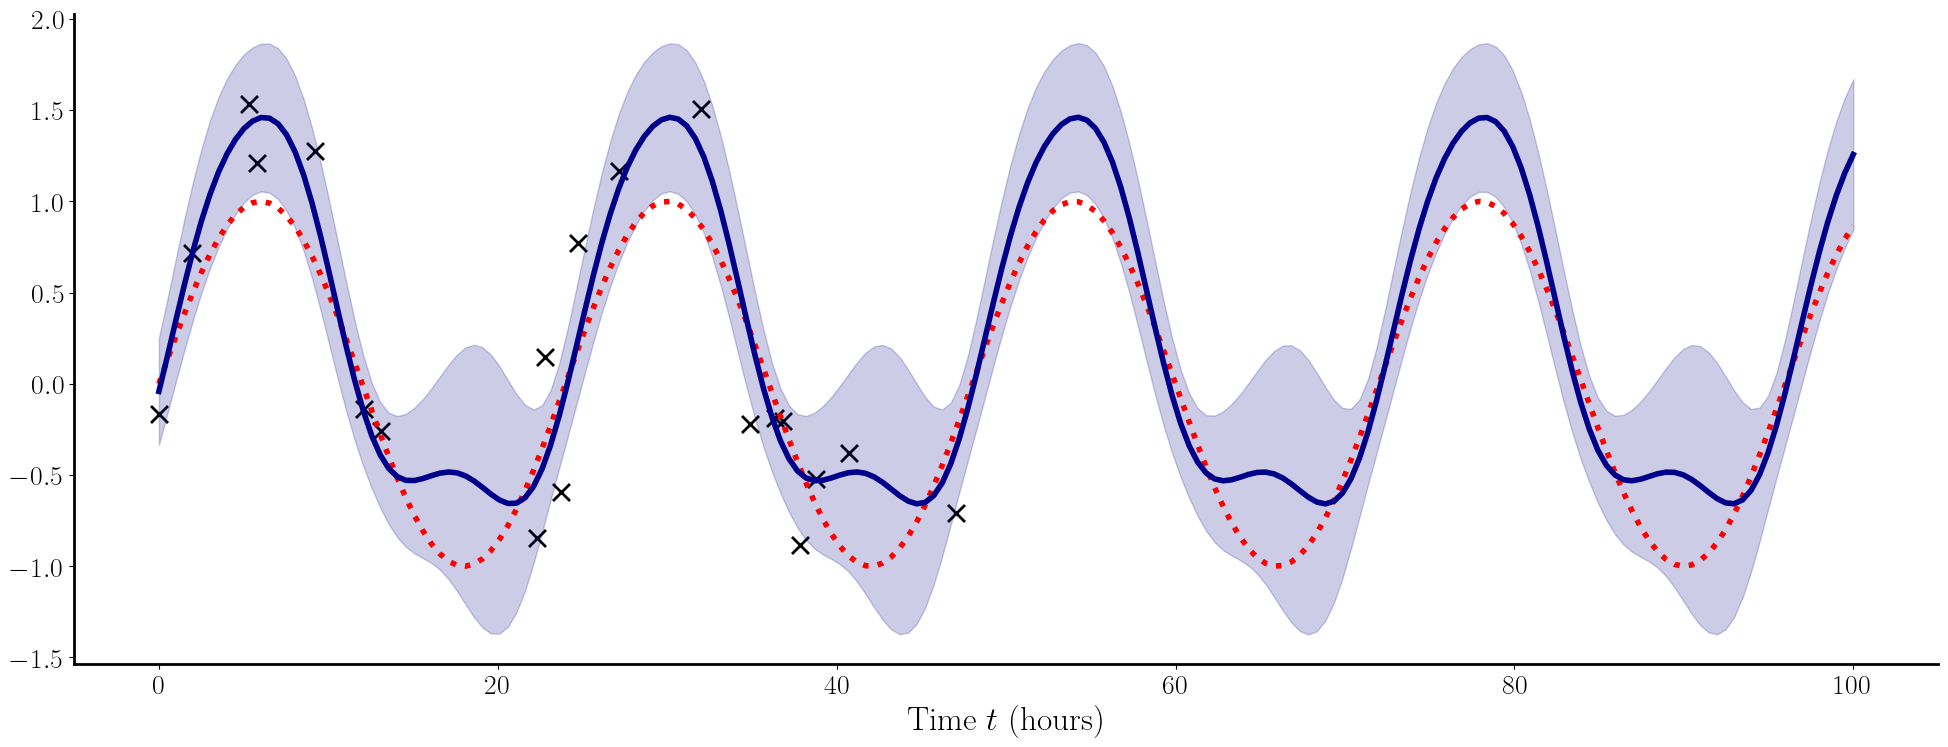

In [17]:
preds_per = model_per(t_OOD)
mean_per = preds_per.mean
var_per = preds_per.variance

with torch.no_grad():
        fig, axes = plt.subplots(1, 1, figsize=(20,8))
        axes.plot(t_OOD, f_OOD, linestyle='dotted', color='red', linewidth=4) # latent function
        axes.scatter(train_x, train_y, marker='x', color='black', s=150) # noisy observations data

        axes.plot(t_OOD, mean_per, color='darkblue', linewidth=4)
        axes.fill_between(t_OOD, mean_per - 2*torch.sqrt(var_per), mean_per + 2*torch.sqrt(var_per),
                           alpha=.2, color='darkblue')
        axes.set_xlabel('Time $t$ (hours)')
        fig.tight_layout()
        plt.show()

In [18]:
print(f'Period: {model_per.covar_module.base_kernel.period_length.item()}')
print(f'Amplitude: {model_per.covar_module.outputscale.item()}')
print(f'Lengthscale: {model_per.covar_module.base_kernel.lengthscale.item()}')
print(f'Noise: {model.likelihood.noise.item()}')

Period: 23.99999999996225
Amplitude: 0.7809229079969002
Lengthscale: 1.0413429916270924
Noise: 0.146043602916491


Autrement, on peut également fixer un prior sur la période, tout comme sur chacun des hyperparamètres. On peut voir ça comme une contrainte mais douce (C'est même exactement ça: Prior <=> régularisation <=> optimisation sous contrainte). D'ordinaire, tous ces hyperparamètres étant positifs, il faudrait un prior défini sur $R_+$ uniquement. Mais ici, on peut simplement mettre une loi normale centrée en 24 avec une légère variance: la probabilité d'obtenir un tirage négatif est extrêmement faible à moins d'une variance elevée.

/opt/miniconda3/lib/python3.9/site-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
/opt/miniconda3/lib/python3.9/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/opt/miniconda3/lib/python3.9/site-packages/botorch/optim/fit.py:130: OptimizationWarning: `scipy_minimize` terminated with status 3, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNSRCH
  warn(


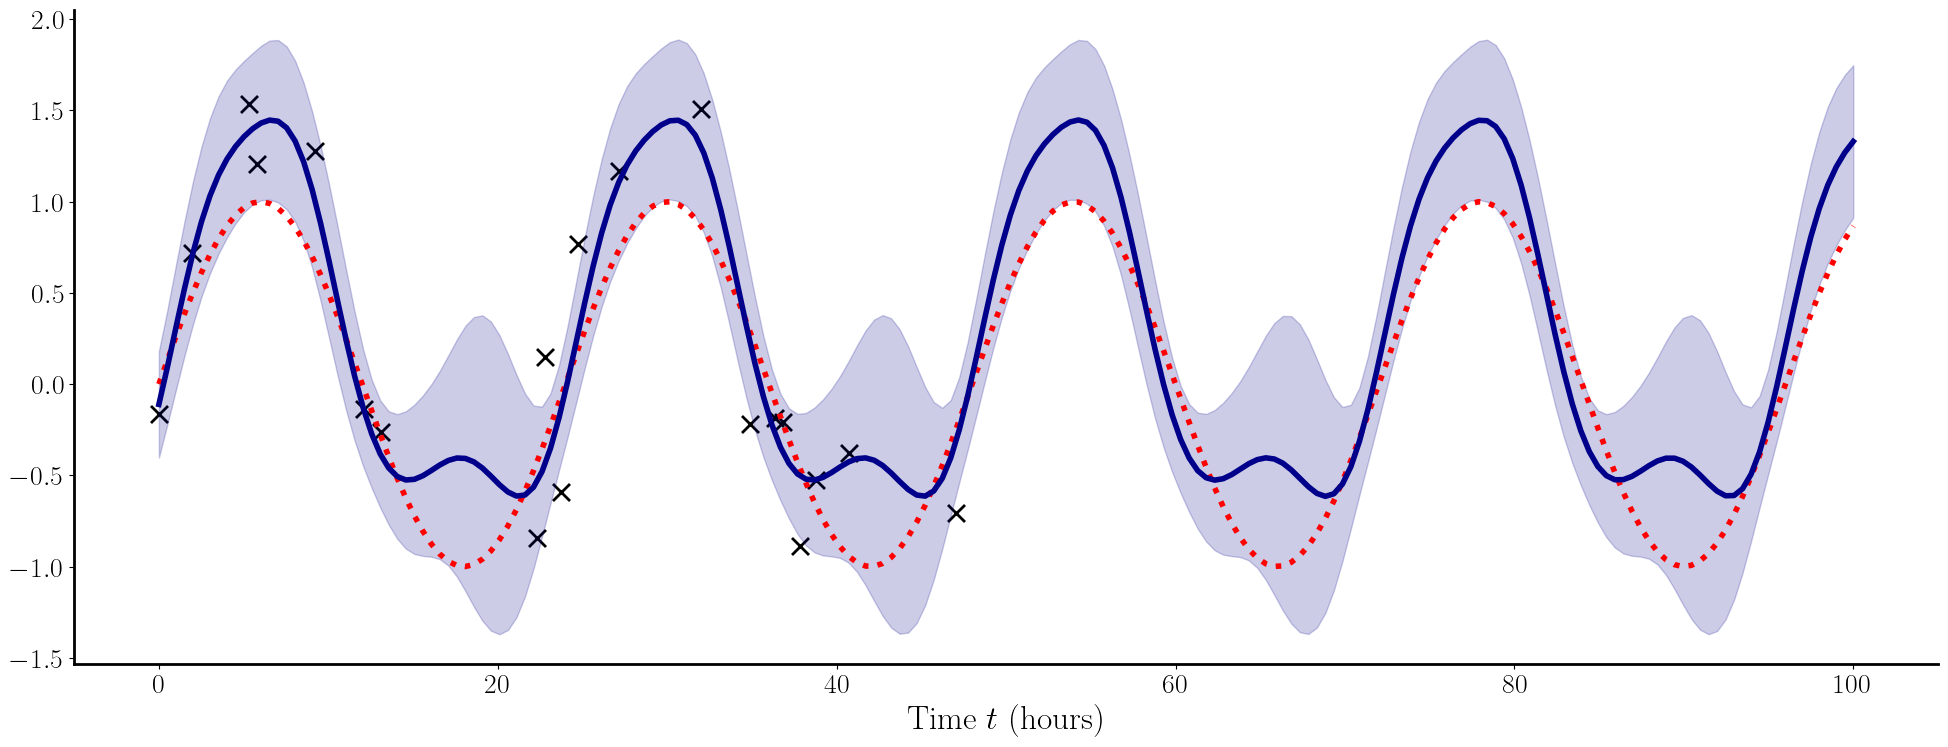

In [19]:
period_prior= NormalPrior(24, 1)
k_per = ScaleKernel(PeriodicKernel(period_length_prior=period_prior,
                                   lengthscale_prior=gpytorch.priors.GammaPrior(concentration=.9, rate=0.5)))
model_per = SingleTaskGP(train_x, train_y,
                     covar_module=k_per)

mll_per = ExactMarginalLogLikelihood(model_per.likelihood, model_per)
fit_gpytorch_model(mll_per, max_retries=10);

preds_per = model_per(t_OOD)
mean_per = preds_per.mean
var_per = preds_per.variance

with torch.no_grad():
        fig, axes = plt.subplots(1, 1, figsize=(20,8))
        axes.plot(t_OOD, f_OOD, linestyle='dotted', color='red', linewidth=4) # latent function
        axes.scatter(train_x, train_y, marker='x', color='black', s=150) # noisy observations data

        axes.plot(t_OOD, mean_per, color='darkblue', linewidth=4)
        axes.fill_between(t_OOD, mean_per - 2*torch.sqrt(var_per), mean_per + 2*torch.sqrt(var_per),
                           alpha=.2, color='darkblue')
        axes.set_xlabel('Time $t$ (hours)')
        fig.tight_layout()
        plt.show()

ça marche aussi, mais le résultat n'est pas très satisfaisant (tu peux jeter un oeil dès qu'on augmente la variance du prior, ça déconne pas mal ou bien il faut commencer à regarder les priors du lengthscale et amplitude aussi...)